In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA
# Reading in the data
df = pd.read_csv("beer_profile_and_ratings.csv")

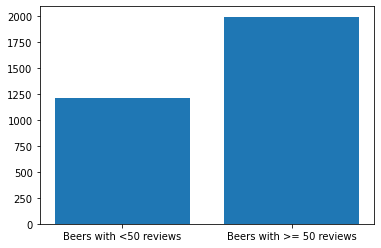

In [2]:
# A lot of beers have a limited amount of reviews
# Let's try to visualize how many there are
plt.bar(["Beers with <50 reviews", "Beers with >= 50 reviews"], [df[df['number_of_reviews'] < 50].shape[0], df[df['number_of_reviews'] >= 50].shape[0]])
plt.show()

# Since we want to use only truthful reviews,
# the beers having less than 50 reviews are dropped
df.drop(df[df['number_of_reviews'] < 50].index, inplace = True)
df.reset_index(inplace = True, drop = True)

[]

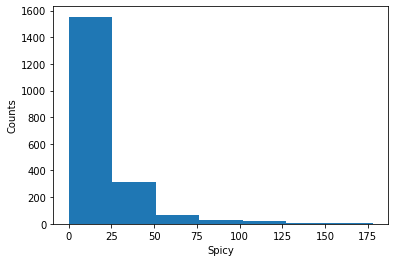

In [3]:
# Some of the dataset columns are extremly lopsided
# Here's an example:
plt.hist(df['Spices'], bins=7)
plt.xlabel('Spicy')
plt.ylabel('Counts')
plt.plot()

In [4]:
# Create the new, categorical columns (before deleting the old ones)
# All the columns are gonna be deleted, except ABV and review_overall
all_features = list(df.columns)
all_features.remove('review_overall')
all_features.remove('ABV')
categorical_columns = ['Astringency', 'Body', 'Bitter', 'Sweet', 'Sour', 'Fruits', 'Spices']

labels = [0, 1, 2, 3]
for i in range(len(categorical_columns)):
    column = categorical_columns[i]
    
    # Here, we're trying to split the data into bins of +/- equal size
    # However, since some values appear more than 1/4 of the time (as for example salty appears 1527 with value 0)
    # There's no solution but to increase the lower bound of the next interval (and all the ones following)
    theSplit = np.array_split(np.sort(df[column]), 4)
    intervals = list(map(lambda x: x[0], theSplit))
    for i in range(1, len(intervals)):
        if intervals[i] <= intervals[i - 1]:
            intervals[i] = intervals[i - 1] + 1
    intervals.append(theSplit[-1][-1])
    
    categorized = pd.cut(df[column], bins = intervals, labels = labels, include_lowest = True)
    df.insert(i + 2, column.lower(), categorized)

# Drop the unnecessary/useless columns
df.drop(all_features, axis = 1, inplace = True)
df.shape

(1990, 9)

In [5]:
# the manually selected interval bounds
# high-quality beers are the ones with >=4.5 rating
# good beers have rating between 4 and 4.5
# average beers have ratings between 3.5 and 4
# and bad beers have ratings under 3.5
intervals = [1, 3.5, 4, 4.5, 5]

# creating the features and labels 
X = df.drop(['review_overall'], axis = 1)
y = pd.cut(df['review_overall'], bins = intervals, labels = labels, include_lowest = True)
y.value_counts()

1    1067
2     572
0     335
3      16
Name: review_overall, dtype: int64

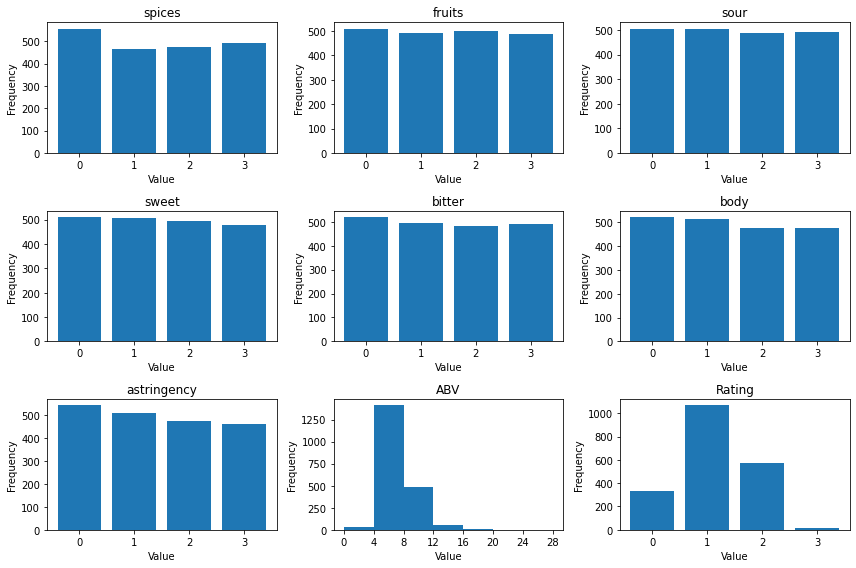

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    if i < X.shape[1] - 1:
        valueCounts = X.iloc[:, i].value_counts()
        ax.bar(valueCounts.index, valueCounts.values)
        ax.set_title(X.columns[i])
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    elif i == X.shape[1] - 1:
        hist, bins, _ = ax.hist(X.iloc[:, i], bins=7)
        ax.set_title(X.columns[i])
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_xticks(bins)
    else:
        ax.bar(y.value_counts().index, y.value_counts().values)
        ax.set_title("Rating")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

plt.tight_layout()

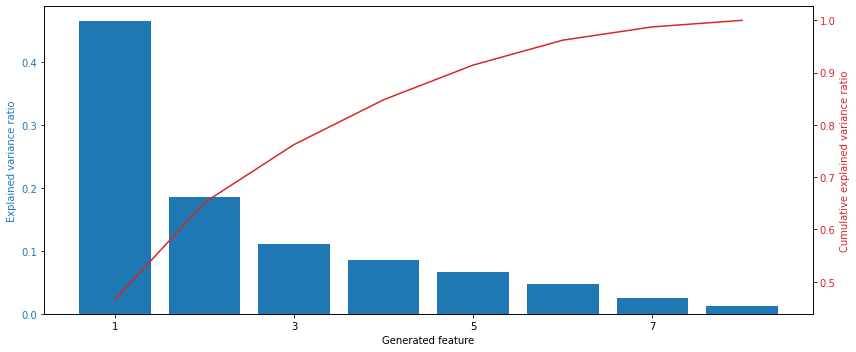

In [7]:
# Let's try to apply PCA on the data before using the second method
N = X.shape[1]
pca = PCA(n_components = N)
X_transformed = pca.fit_transform(X)

fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()


In [8]:
# Notice that the first 3 generated features have variance ratio above 0.1
# so we'll be using N = 3 during our PCA training
N = 3
# Additionally, to get some real-world feel of what these features mean
# Let's print the columns the correlate the most with each new feature:
dimensionCorr = pd.DataFrame(pca.components_,columns=X.columns).abs().idxmax(axis = 'columns')
for i in range(N):
    print(f"The feature correlating the most with new feature nr. {i + 1} is {dimensionCorr[i]}")

The feature correlating the most with new feature nr. 1 is ABV
The feature correlating the most with new feature nr. 2 is sour
The feature correlating the most with new feature nr. 3 is bitter


In [9]:
# splitting data into train/test
stratKFold = StratifiedKFold(shuffle = True)

# lists to save the train accuracies, validation accuracies, and the models themselves
y_train_acc_rfc = []
y_valid_acc_rfc = []
y_train_acc_lg = []
y_valid_acc_lg = []
rfcs = []
lgs = []

for tr, val in stratKFold.split(X, y):
    X_train = X.iloc[tr] 
    X_val   = X.iloc[val]
    y_train = y.iloc[tr]
    y_val   = y.iloc[val]

    # creating and training the model
    rfc = RandomForestClassifier(criterion = 'gini', min_samples_split = 10)
    rfc.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(rfc.predict(X_train), y_train)
    y_train_acc_rfc.append(train_accuracy)

    valid_accuracy = accuracy_score(rfc.predict(X_val), y_val)
    y_valid_acc_rfc.append(valid_accuracy)
    rfcs.append(rfc)

    pca = PCA(n_components = N)
    X_train_tf = pca.fit_transform(X_train)
    X_val_tf   = pca.transform(X_val)

    lg = LogisticRegression()
    lg.fit(X_train_tf, y_train)
    train_accuracy_lg = accuracy_score(lg.predict(X_train_tf), y_train)
    y_train_acc_lg.append(train_accuracy_lg)

    valid_accuracy_lg = accuracy_score(lg.predict(X_val_tf), y_val)
    y_valid_acc_lg.append(valid_accuracy_lg)

    lgs.append((lg, pca))
    
bestRFCval   = np.argmax(y_valid_acc_rfc)
bestRFCtrain = np.argmax(y_train_acc_rfc)
bestLGval   = np.argmax(y_valid_acc_lg)
bestLGtrain = np.argmax(y_train_acc_lg) 
print(f"The best train accuracy is achieved during fold {1 + bestRFCtrain} and it is equal to {y_train_acc_rfc[bestRFCtrain]}.")
print(f"The best validation accuracy is achieved during fold {1 + bestRFCval} and it is equal to {y_valid_acc_rfc[bestRFCval]}.")
print(f"When using PCA, the best train accuracy is achieved during fold {1 + bestLGtrain} and it is equal to {y_train_acc_lg[bestLGtrain]}")
print(f"When using PCA, the best validation accuracy is achieved during fold {1 + bestLGval} and it is equal to {y_valid_acc_lg[bestLGval]}")

The best train accuracy is achieved during fold 1 and it is equal to 0.7971105527638191.
The best validation accuracy is achieved during fold 3 and it is equal to 0.6331658291457286.
When using PCA, the best train accuracy is achieved during fold 4 and it is equal to 0.5891959798994975
When using PCA, the best validation accuracy is achieved during fold 3 and it is equal to 0.592964824120603


Text(0.5, 1.0, 'Best Case LG Confusion Matrix')

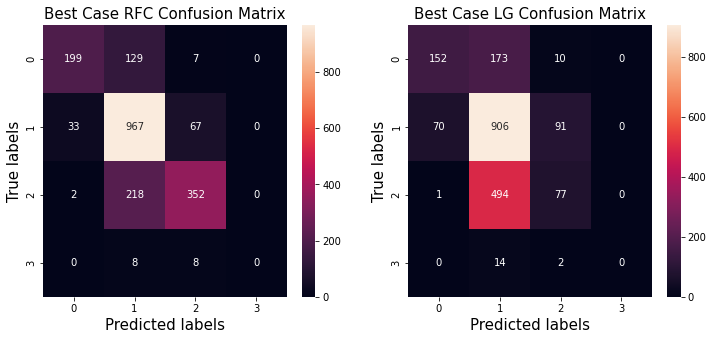

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y, rfcs[bestRFCval].predict(X)), annot=True, fmt='g', ax=ax1)
ax1.set_xlabel('Predicted labels',fontsize=15)
ax1.set_ylabel('True labels',fontsize=15)
ax1.set_title('Best Case RFC Confusion Matrix',fontsize=15)

sns.heatmap(confusion_matrix(y, lgs[bestLGval][0].predict(lgs[bestLGval][1].transform(X))), annot=True, fmt='g', ax=ax2)
ax2.set_xlabel('Predicted labels', fontsize=15)
ax2.set_ylabel('True labels', fontsize=15)
ax2.set_title('Best Case LG Confusion Matrix', fontsize=15)